In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import math
import pickle
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import anndata as ad
import scipy.io as sio

from os.path import join
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
import gc

from sklearn.preprocessing import normalize
from sklearn.utils.extmath import randomized_svd

import sys
sys.path.insert(0, '../../')
from src.ace import ACE
from src.utils import nn_approx
from src.preprocessing import lsiTransformer, ADTransformer
from imp_evaluation import *

## loading data

In [3]:
data_dir = "../../data/PBMC-Mult"

print('Reading `mtx` files...')
rna_norm_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'rna_mat_norm.mtx')).T)
atac_norm_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'atac_mat_norm.mtx')).T)

rna_names = pd.read_csv(join(data_dir, 'gene_names.csv'))['x'].to_numpy()
atac_names = pd.read_csv(join(data_dir, 'atac_names.csv'))['x'].to_numpy()

cell_names = pd.read_csv(join(data_dir, 'cell_names.csv'))['x'].to_numpy()
meta_data = pd.read_csv(join(data_dir, 'metadata.csv'), index_col=0)
meta_data['batch'] = 'batch1'

train_idx = pd.read_csv(join(data_dir, 'train_idx.csv'))['0'].to_numpy()
test_idx  = pd.read_csv(join(data_dir, 'test_idx.csv'))['0'].to_numpy()

hvp_idx = np.argsort(atac_norm_mat.sum(axis=0).A1)[-20000:]
hvp_names = atac_names[hvp_idx]

input_train_mod1 = sc.AnnData(sps.csr_matrix(rna_norm_mat[train_idx]), obs=meta_data.loc[cell_names[train_idx]])
input_test_mod1 = sc.AnnData(sps.csr_matrix(rna_norm_mat[test_idx]), obs=meta_data.loc[cell_names[test_idx]])
input_train_mod2 = sc.AnnData(sps.csr_matrix(atac_norm_mat[train_idx][:, hvp_idx]), obs=meta_data.loc[cell_names[train_idx]])
input_test_mod2 = sc.AnnData(sps.csr_matrix(atac_norm_mat[test_idx][:, hvp_idx]), obs=meta_data.loc[cell_names[test_idx]])
input_train_mod1.var_names = input_test_mod1.var_names = rna_names
input_train_mod2.var_names = input_test_mod2.var_names = hvp_names

# select hvg for evaluation
ad_rna = sc.AnnData(rna_norm_mat, obs=meta_data.loc[cell_names])
sc.pp.highly_variable_genes(ad_rna, n_top_genes=5000)
hvg_idx = np.where(ad_rna.var.highly_variable)[0]

Reading `mtx` files...


In [4]:
log_dir = '../../outputs/PBMC-Mult-imp'

## RNA->ATAC

In [5]:
os.makedirs(join(log_dir, 'RNA2ATAC'), exist_ok=True)
gex = input_train_mod1.copy()
gex_test = input_test_mod1.copy()
other = input_train_mod2.copy()
other_test = input_test_mod2.copy()

#### preprocessing
if not os.path.exists(join(log_dir, 'RNA2ATAC/gex_train_input.npy')):
    ### GEX preprocessing
    gex_all = sc.concat([gex, gex_test])
    lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, 
    )
    gex_all_lsi_df = lsi_former.fit_transform(gex_all)
    gex_all_lsi_arr = gex_all_lsi_df.values
    gex.obsm['X_pca'], gex_test.obsm['X_pca'] = gex_all_lsi_arr[:gex.shape[0]], gex_all_lsi_arr[gex.shape[0]:]

    del gex_all, gex_all_lsi_df, gex_all_lsi_arr
    gc.collect()

    # ATAC processing
    atac_lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, 
    )
    other.obsm['X_lsi'] = atac_lsi_former.fit_transform(other).values
    other_test.obsm['X_lsi'] = np.zeros((other_test.shape[0], 192))

    np.save(join(log_dir, 'RNA2ATAC/gex_train_input.npy'), gex.obsm['X_pca'])
    np.save(join(log_dir, 'RNA2ATAC/gex_test_input.npy'),  gex_test.obsm['X_pca'])
    np.save(join(log_dir, 'RNA2ATAC/other_train_input.npy'), other.obsm['X_lsi'])
    # np.save(join(log_dir, 'RNA2ATAC/other_test_input.npy'),  other_test.obsm['X_lsi'])
else:
    gex.obsm['X_pca']        = np.load(join(log_dir, 'RNA2ATAC/gex_train_input.npy'))
    gex_test.obsm['X_pca']   = np.load(join(log_dir, 'RNA2ATAC/gex_test_input.npy'))
    other.obsm['X_lsi']      = np.load(join(log_dir, 'RNA2ATAC/other_train_input.npy'))
    other_test.obsm['X_lsi'] = np.zeros((other_test.shape[0], 192))


In [6]:
n_parts = 2
modBatch_dict = {
    'rna': [gex, gex_test],
    'atac': [other, None]
}

useReps_dict = {
    'rna': 'X_pca',
    'atac': 'X_lsi'
}

In [7]:
# building stage 1
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'atac':[1024, 512]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'atac':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir=join(log_dir, 'RNA2ATAC'),
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'atac']
batch1: ['rna']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=3.4647, temp=10.0000, batch0 loss=3.4647, 
Epoch 19, loss=3.1098, temp=10.0000, batch0 loss=3.1098, 
Epoch 29, loss=2.9865, temp=10.0000, batch0 loss=2.9865, 
Epoch 39, loss=2.9238, temp=10.0000, batch0 loss=2.9238, 
Epoch 49, loss=2.8680, temp=10.0000, batch0 loss=2.8680, 
Epoch 59, loss=2.8254, temp=10.0000, batch0 loss=2.8254, 
Epoch 69, loss=2.7757, temp=10.0000, batch0 loss=2.7757, 
Epoch 79, loss=2.7663, temp=10.0000, batch0 loss=2.7663, 
Epoch 89, loss=2.7357, temp=10.0000, batch0 loss=2.7357, 
Epoch 99, loss=2.7078, temp=10.0000, batch0 loss=2.7078, 


In [8]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['rna']]
)
ad_integ

AnnData object with n_obs × n_vars = 10411 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_annotations', 'batch', 'raw_batch', 'domain'

In [11]:
# impute
modBatch_dict['atac'][0].X = binarize(modBatch_dict['atac'][0].X)
imputed_data = model.impute(modBatch_dict, output_key1='stage1_emb', knn=20, verbose=True)
Y_hat = imputed_data['atac'][1]

batch 0: no need for imputation
batch 1: impute => ['atac']


## ATAC -> RNA

In [12]:
os.makedirs(join(log_dir, 'ATAC2RNA'), exist_ok=True)
gex = input_train_mod1.copy()
other = input_train_mod2.copy()
gex_test = input_test_mod1.copy()
other_test = input_test_mod2.copy()

#### preprocessing
if not os.path.exists(join(log_dir, 'ATAC2RNA/gex_train_input.npy')):
    ### GEX preprocessing
    lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, 
    )
    gex.obsm['X_pca'] = lsi_former.fit_transform(gex).values
    gex_test.obsm['X_pca'] = np.zeros((gex_test.shape[0], 192))

    # ATAC processing
    atac_all = sc.concat([other, other_test])
    atac_lsi_former = lsiTransformer(192, drop_first=True, use_highly_variable=False, log=False, norm=False, 
                                z_score=True, tfidf=False, svd=True, 
    )
    other_all_arr = atac_lsi_former.fit_transform(atac_all).values
    other.obsm['X_lsi'], other_test.obsm['X_lsi'] = other_all_arr[:other.shape[0]], other_all_arr[other.shape[0]:]

    np.save(join(log_dir, 'ATAC2RNA/gex_train_input.npy'), gex.obsm['X_pca'])
    np.save(join(log_dir, 'ATAC2RNA/other_train_input.npy'), other.obsm['X_lsi'])
    np.save(join(log_dir, 'ATAC2RNA/other_test_input.npy'), other_test.obsm['X_lsi'])
else:
    gex.obsm['X_pca'] = np.load(join(log_dir, 'ATAC2RNA/gex_train_input.npy'))
    other.obsm['X_lsi'] = np.load(join(log_dir, 'ATAC2RNA/other_train_input.npy'))
    other_test.obsm['X_lsi'] = np.load(join(log_dir, 'ATAC2RNA/other_test_input.npy'))

In [13]:
n_parts = 2
modBatch_dict = {
    'rna': [gex, None],
    'atac': [other, other_test]
}

useReps_dict = {
    'rna': 'X_pca',
    'atac': 'X_lsi'
}

In [14]:
# building stage 1
T = 0.1
model = ACE(
    modBatch_dict=modBatch_dict,  
    useReps_dict=useReps_dict,  
    batch_key='batch', 
    layers_dims = {'rna': [1024, 512], 'atac':[1024, 512]}, # consistent across all experiments
    dropout_rates = {'rna':[0.2, 0.2], 'atac':[0.2, 0.2]},  # consistent across all experiments
    T=math.log(1./T), T_learnable=False, log_dir=join(log_dir, 'ATAC2RNA'),
    n_latent1=40, n_latent2=256, seed=1234, num_workers=0
)

model.stage1_fit(
    batch_size=512,
    epochs=100,
    lr=2e-4, 
    log_step=10, 
)

batch0: ['rna', 'atac']
batch1: ['atac']
Batch ids used in training:  [0]
Training stage1
Epoch 9, loss=3.4233, temp=10.0000, batch0 loss=3.4233, 
Epoch 19, loss=3.0869, temp=10.0000, batch0 loss=3.0869, 
Epoch 29, loss=2.9548, temp=10.0000, batch0 loss=2.9548, 
Epoch 39, loss=2.8913, temp=10.0000, batch0 loss=2.8913, 
Epoch 49, loss=2.8442, temp=10.0000, batch0 loss=2.8442, 
Epoch 59, loss=2.7966, temp=10.0000, batch0 loss=2.7966, 
Epoch 69, loss=2.7558, temp=10.0000, batch0 loss=2.7558, 
Epoch 79, loss=2.7349, temp=10.0000, batch0 loss=2.7349, 
Epoch 89, loss=2.7134, temp=10.0000, batch0 loss=2.7134, 
Epoch 99, loss=2.6891, temp=10.0000, batch0 loss=2.6891, 


In [15]:
# stage1 inference
ad_integ = model.stage1_infer(
    modBatch_dict, useReps_dict, output_key='stage1_emb', 
    specify_mods_perBatch=[['rna'], ['atac']]
)
ad_integ

AnnData object with n_obs × n_vars = 10411 × 40
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_annotations', 'batch', 'raw_batch', 'domain'

In [16]:
# impute
imputed_data = model.impute(modBatch_dict, output_key1='stage1_emb', knn=20, verbose=True)
X_hat = imputed_data['rna'][1]

batch 0: no need for imputation
batch 1: impute => ['rna']


## evaluation

In [17]:
# rna->atac
x, y = binarize(other_test.X.A), Y_hat

auc = roc_auc_score(x.flatten(), y.flatten())
rmse = np.sqrt(((x.flatten()-y.flatten())**2).mean())

auc_along_peak, rmse_along_peak = eval_aucRmse_AlongPeak(x, y)
auc, np.mean(auc_along_peak)

(0.749023229662005, 0.6135250250134427)

In [18]:
# atac->rna
# gex_test = input_test_mod1.copy()

pear1, spear1, rmse = eval_imputation_flatten(gex_test[:,hvg_idx].X.A.flatten(), X_hat[:,hvg_idx].flatten())

pear_along_gene, spear_along_gene = eval_PearSpear_AlongGene(gex_test[:,hvg_idx].X.A, X_hat[:,hvg_idx])

np.mean(pear_along_gene), np.mean(spear_along_gene)

Found pearson's correlation/p of 0.7111/0
Found spearman's collelation/p of 0.3775/0
Found rmse 0.2964


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


(0.13308554529659605, nan)

## Visualization

In [19]:
ad_rna_imputed = sc.AnnData(X_hat.copy(), obs=meta_data.loc[cell_names[test_idx]].copy())
ad_atac_imputed = sc.AnnData(Y_hat.copy(), obs=meta_data.loc[cell_names[test_idx]].copy())

ad_rna_imputed = get_umap(ad_rna_imputed, scale=False, norm=False)
ad_atac_imputed = get_umap(ad_atac_imputed, scale=False, norm=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [20]:
ad_rna_test = input_test_mod1.copy()
ad_atac_test = input_test_mod2.copy()
ad_atac_test.X = sps.csr_matrix(binarize(ad_atac_test.X.A))

# concat all 
ad_rna_test.obs['mod'] = 'truth'
ad_rna_imputed.obs['mod'] = 'pred'
ad_rna_concat = sc.AnnData(np.vstack([ad_rna_test.X.A, X_hat.copy()]), obs=pd.concat([ad_rna_test.obs, ad_rna_imputed.obs]))

ad_atac_test.obs['mod'] = 'truth'
ad_atac_imputed.obs['mod'] = 'pred'
ad_atac_concat = sc.AnnData(np.vstack([ad_atac_test.X.A, Y_hat.copy()]), obs=pd.concat([ad_atac_test.obs, ad_atac_imputed.obs]))

ad_rna_concat = get_umap(ad_rna_concat, scale=False, norm=False)
ad_atac_concat = get_umap(ad_atac_concat, scale=False, norm=False)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'seurat_annotations'}, xlabel='UMAP1', ylabel='UMAP2'>

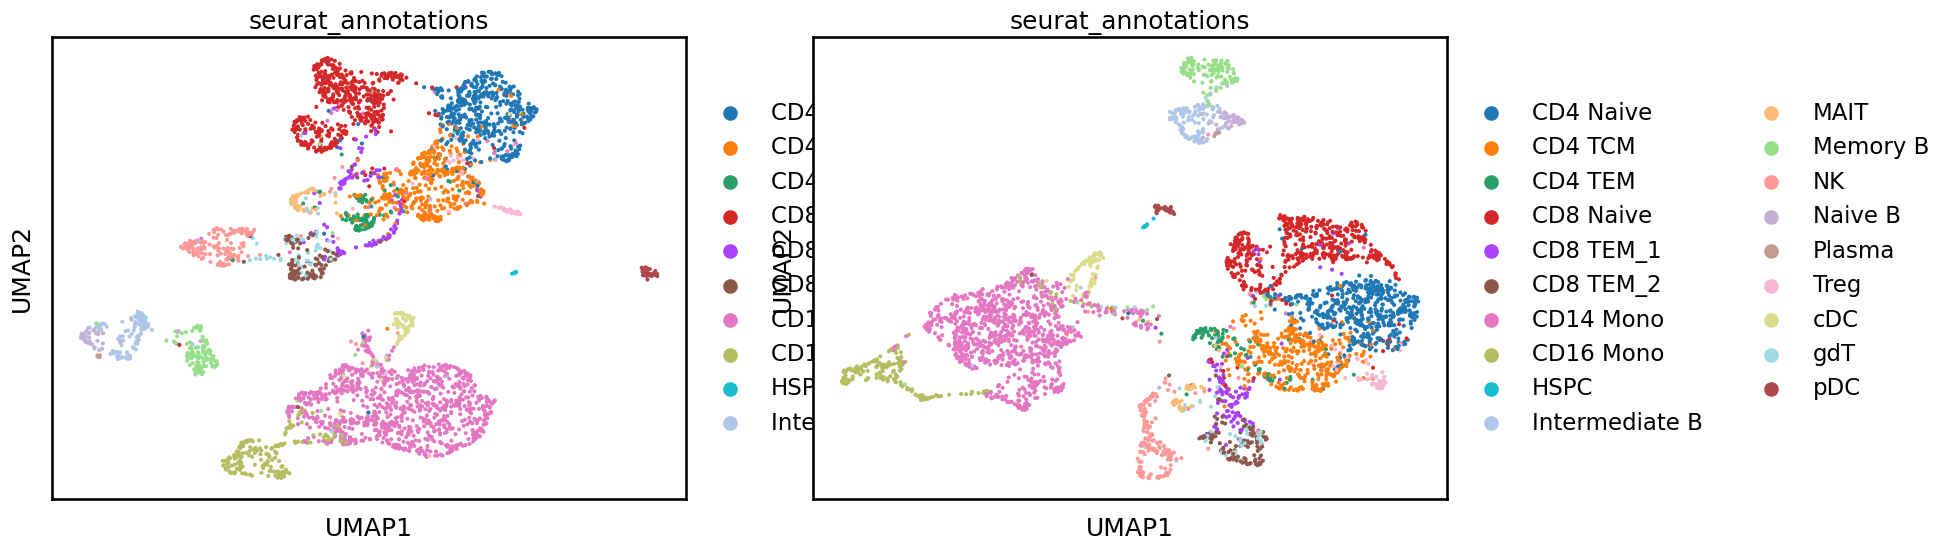

In [21]:
_, axes = plt.subplots(1, 2, figsize=(18, 6))

sc.pl.umap(ad_rna_imputed, color='seurat_annotations', ax=axes[0], show=False)
sc.pl.umap(ad_atac_imputed, color='seurat_annotations', ax=axes[1], show=False)

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


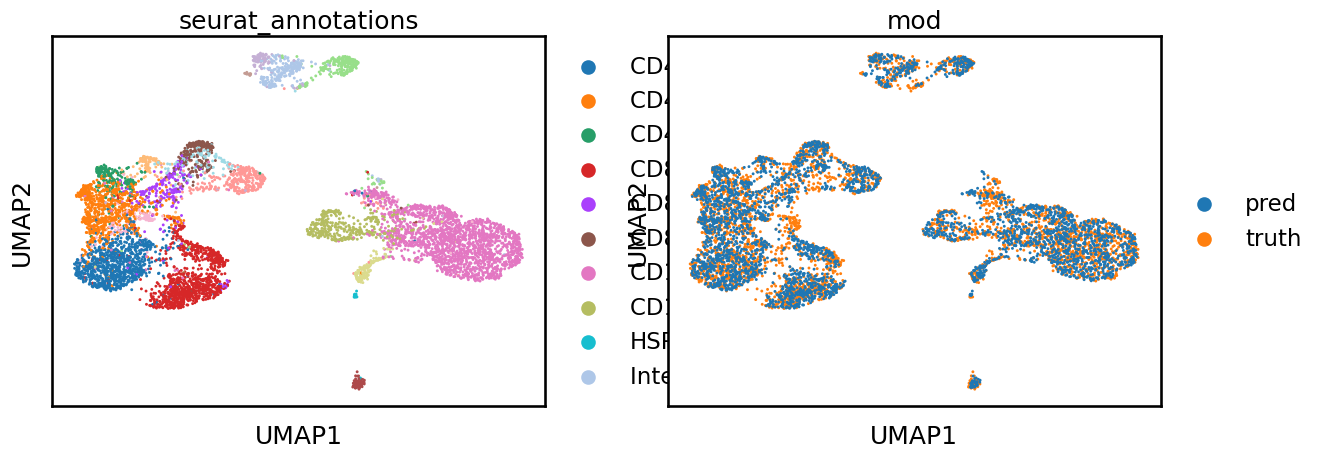

In [22]:
sc.pl.umap(ad_rna_concat, color=['seurat_annotations', 'mod'])

/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:163: PendingDeprecationWarning: The get_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps[name]`` instead.
  cmap = copy(get_cmap(cmap))
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yanxh/anaconda3/envs/torch112/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


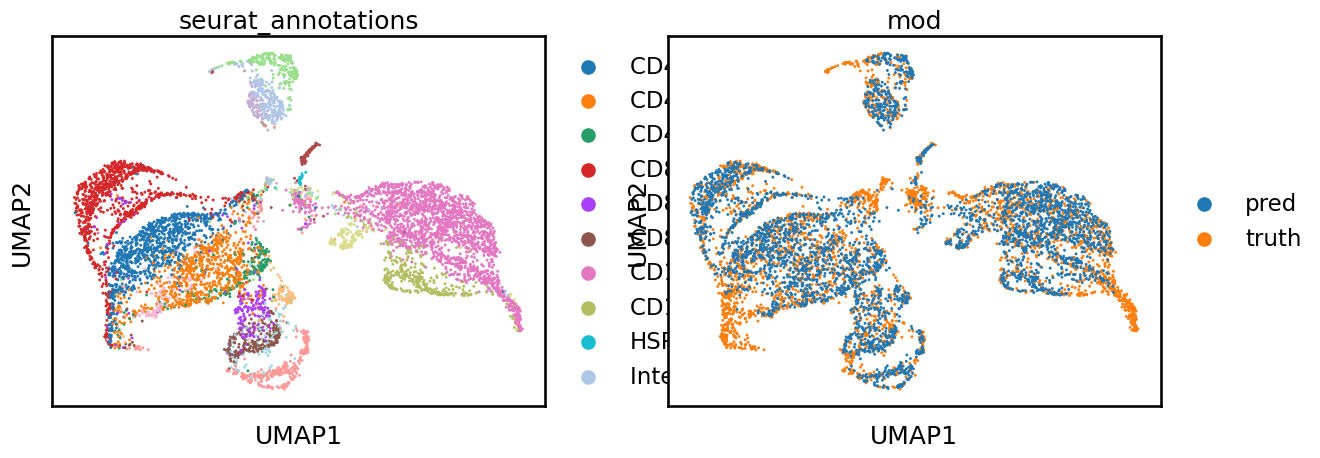

In [23]:
sc.pl.umap(ad_atac_concat, color=['seurat_annotations', 'mod'])